# Session 6: Continuous Control with Deep Deterministic Policy Gradient

## Setups

In [1]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls

# #gym
# !pip install gym #For full installations, see https://github.com/openai/gym#installation

# #displays
# !pip install pyvirtualdisplay
# !sudo apt-get install xvfb

# #torch and numpy
# !pip install numpy 
# !pip install torch torchvision
# import torch
# torch.__version__

## Imports

In [2]:
%matplotlib inline

#environments
import gym
gym.logger.set_level(40)

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#use cuda 0 if available; assuming 1 gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#misc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime
from collections import Counter, deque

#solutions
from solutions.memory import VanillaMemory
from solutions.agents import DDPGAgent

#shut up warnings
import warnings
warnings.filterwarnings("ignore")

MODEL_PATH = 'models/'

## Animation Imports

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

## Recap: Policy-based vs Value-based

Here are some advantages of policy-based and value-based learning taken from [Bridging the Gap Between Value and Policy Based
Reinforcement Learning](https://arxiv.org/pdf/1702.08892.pdf) by Google Brain.

### Policy-based Learning

<img src="img/policygradient.png" alt="PG"/>

1. **Simplicity** - directly optimizes policy
2. **True stochastic policy** - the policy network itself gives probabilities
3. **Continuous actions are easier** - policy network can output both discrete and continuous actions
4. **Low bias but high variance** - since we usually train on Monte Carlo baselines

### Value-based Learning

<img src="img/dqn.png" alt="DQN"/>

1. **Reuse transitions** - store transitions in replay memory to be resued again
2. **Decorrelated samples** - randomly sample from replay memory regardless of trajectories
3. **Evaluate states and actions** - give you estimation of how "good" a state or action is
4. **Biased but low variance** - since we train using value baselines

### Actor-critic

<img src="img/ddpg.png" alt="DDPG"/>

Example: deep deterministic policy gradient (DDPG)

1. Actor (policy) network to do stochastic actions
2. Replay memory to resuse the transitions
3. Minimize variance and bias

## [Pendulum-v0](https://github.com/openai/gym/wiki/Pendulum-v0)

`The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.`

In [4]:
env = gym.make('Pendulum-v0')
state = env.reset()
score = 0
t=0
frames = []

while True:
    action = 4 * np.random.rand(1) - 1
    state, reward, done, info = env.step(action)
    t+=1
    score+=reward
    
    frames.append(env.render(mode = 'rgb_array'))
    if done: break
print(f'Done in {t} timsteps with score {score}.')

Done in 200 timsteps with score -1215.7426884473107.


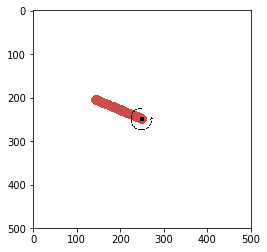

In [5]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())

**Coding Assignment** Before we dive in, let us do some warm-up exercises of finding out more about `Pendulum-v0`

* State space
* Action space
* Rewards - It does not get anything for finishing the game but what about during the game?
* How many episodes does it take for the game to end

Hint: You can always look at its [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

In [ ]:
#create environment
env = gym.make('Pendulum-v0')
env.reset()

'''
Write your code here
'''


## Deep Deterministic Policy Gradient (DDPG)

Deep deterministic policy gradient (DDPG) is first introduced in the paper [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971). It consists of the following main components:

1. **Critic Networks** - two neural networks that take an input of state and action and output action values; equivalent to Q networks of DQN
2. **Actor Networks** - two neurla networks that take an input of state and output action; equivalent to policy networks of policy gradient
3. **Agent** - a class that wraps around actors and critics
3. **Replay Memory** - a data sampler than sample `(state, action, reward, next state)` tuples for training

<img src="img/ddpg.png" alt="DDPG"/>

where the green lines denote the process of infering an action (either "best" or random), red lines denote the process of updating the critic network, and blue lines denote the process of updating the actor network.

### Actor Networks

This has the exact same architecture as policy network of vanilla policy gradient.

**Coding Assignment** Fill in the `forward` method to take in state and return action as **a real number between -2 and 2**.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd.variable import Variable

class ActorNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed=1412):
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.head = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        '''
        Write your code here
        '''

### Critic Networks

This is where the true trick of DDPG is. Instead of a Q network that takes in state and output one action value for each action, critic networks take in **state and action** and output **one specific action value for that state-action pair**. You can do that in several ways such as:

**Coding Assignment** Fill in the critic network below to take in **action and state** and output **an action value**.

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed=1412):
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        '''
        Write your code here
        '''
        
    def forward(self, state, action):
        '''
        Write your code here
        '''

### Agent

The agent is almost the same as a DQN agent except that:
1. The action is chosen by the actor (policy network) instead of by the critic (Q network)
2. The `learn` method updates both actor and critic networks

In [ ]:
class DDPGAgent():        
    def __init__(self, 
        state_size, action_size, nb_hidden, replay_memory, action_bounds = [-2,2], random_seed=0, 
        bs = 128, gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, wd_actor=0, wd_critic=0,
        clip_actor = None, clip_critic=None, update_interval = 20, update_times = 10): 

        self.state_size = state_size
        self.action_size = action_size
        self.action_lower = action_bounds[0]
        self.action_upper = action_bounds[1]
        self.seed = random.seed(random_seed)
        self.bs = bs
        self.update_interval = update_interval
        self.update_times = update_times
        self.timestep = 0

        self.gamma = gamma
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.wd_critic = wd_critic
        self.wd_actor = wd_actor
        self.clip_critic=clip_critic
        self.clip_actor = clip_actor
        self.actor_losses = []
        self.critic_losses = []

        #actor
        self.actor_local = ActorNetwork(state_size, action_size, nb_hidden, random_seed).to(device)
        self.actor_target = ActorNetwork(state_size, action_size, nb_hidden, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor,weight_decay=self.wd_actor)

        #critic
        self.critic_local = CriticNetwork(state_size, action_size, nb_hidden, random_seed).to(device)
        self.critic_target = CriticNetwork(state_size, action_size, nb_hidden, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr_critic,weight_decay=self.wd_critic)

        #noise
        self.noise = OUNoise(action_size, random_seed)

        #replay memory
        self.memory = replay_memory
    
    def step(self, state, action, reward, next_state, done):
        #increment timestep
        self.timestep+=1
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory  
        if self.timestep % self.update_interval == 0:
            for i in range(self.update_times):
                if len(self.memory) > self.bs:
                    transitions = self.memory.sample(self.bs)
                    self.learn(transitions)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, self.action_lower, self.action_upper)

    def reset_noise(self):
        self.noise.reset()

    def learn(self, transitions):
        states, actions, rewards, next_states, dones = transitions

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        if self.clip_critic: torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), self.clip_critic)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        if self.clip_actor: torch.nn.utils.clip_grad_norm(self.actor_local.parameters(), self.clip_actor)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)   
           
        self.actor_losses.append(actor_loss.cpu().data.numpy())
        self.critic_losses.append(critic_loss.cpu().data.numpy())        

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

### Ornstein-Uhlenbeck Noise (OU Noise)

For exploration in continuous action, instead of epsilon-greedy policy, we use `OUNoise` to add some randomness to our actions.

In [6]:
import random
import copy
import numpy as np

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed=1412, mu=0., theta=0.15, sigma=0.3):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return(self.state)

**Coding Exercise** See how OUNoise progress as you sample more and more from it. See how this changes as you chnage the hyper parameters.

In [24]:
noise = OUNoise(size=1,seed=1412,mu=0.,theta=0.15,sigma=0.3)

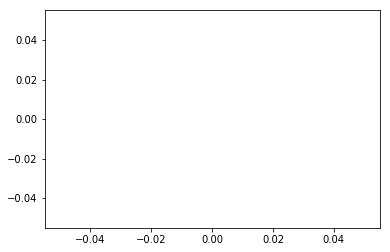

In [25]:
'''
Write your code here
'''
noises = []

plt.plot(noises)

## Train Your Own DDPG Agent

Now that you understand the intuition behind how DDPG works, let try training a model to solve `Pendulum-v0`. There is no official solved score for this environment but we have seen that agents with **a 100-episode average score of more than -400** have been doing well so this is where we will try to achieve during class.

### Tune Hyperparameters

Some hyperparameters are more impactful than others. The only way to know how much each should be is to understand the intuition behind them and experiment with your assumptions. For instance, in this case, the ones you should look out for include but not limited to:

1. `lr` - The higher the learning rate, the faster your agent can learn but be careful not to set it too high otherwise your agent might be 'changing its mind' too fast and end up not learning anything. If your scores oscillate between some low numbers, it is a sign of too high a learning rate.

2. `nb_hidden` - As you can see in `solutions/networks.py`, the Q networks are simply two layers of linear and ReLU. The larger the number of hidden units for each layer, the more abstraction it can handle but it might take you longer to train as well.

3. `tau` - This is basically how fast you want to update your target network. For instance, `tau` of 0.3 means that for each time step, the weights of your target network will be $0.3 * W_{local} + 0.7 * W_{target}$.

4. `capacity` - This is not the agent's hyperparameter but rather its replay memory. The larger this is usually the better performance since the agent can sample more diverse transitions but that comes also with speed of training.

5. `update_interval` and `update_times` - The agent will update the local network every `update_interval` for `update_times` times. Updating your network too often can lead to unstable learning; updating too intermittenly will lead to slow speed of training.

6. `theta` and `sigma` - Adjust parameters of OUNoise to adjust the level of exploration. 

Besides the hyperparameters you can also look at the architecture of your neural networks. For instance, in the solution, critic networks take input as concatenation of state and action but that is not the only way of doing it, you might try:



In [26]:
env = gym.make('Pendulum-v0')
'''
Write your code here:
1. Create a replay memory with any chosen capacity
2. Create a DDPG agent with hyperparameters of your choice; refer to solutions/agents.py
'''

'\nWrite your code here:\n1. Create a replay memory with any chosen capacity\n2. Create a DDPG agent with hyperparameters of your choice; refer to solutions/agents.py\n'

In [ ]:
scores = []
moving_scores = []
scores_avg = deque(maxlen=100)
n_episodes = 200
solved = -400

for episode in tqdm_notebook(range(n_episodes)):
    #get initial states         
    state = env.reset()
    score = 0
    agent.reset_noise()                                             
    
    while True:
        #agent action
        action = agent.act(state)
        next_state,reward,done,info = env.step(action)        
        agent.step(state, action, reward, next_state, done) 
        score += reward                                         
        state = next_state 
        if done: break
            
    #book keeping
    scores.append(score)
    scores_avg.append(score)
    moving_scores.append(np.mean(scores_avg))

    #print scores intermittenly
    if episode % 10 ==0: print(f'Episode: {episode} Score: {score} Average Score: {np.mean(scores_avg)}')

    #break if done
    if (np.mean(scores_avg) > solved):
        print(f'Environment solved in {episode} episodes! Average Score: {np.mean(scores_avg)}')
        break

It is also very useful to look at diagnostics of the models as you train:

* **Scores and average scores** - Your most important indicators. If they are stagnating, you should try tuning your hyperparameters because definitely there is something wrong.
* **Loss of local network** - Counterintuitively to when you train supervised models, a stable loss usually means a bad thing for a DQN agent. This is usually because the agent is either learning too slowly or not learning at all.

In [ ]:
plt.plot(scores)
plt.plot(moving_scores)

In [ ]:
plt.plot(agent.actor_losses)

In [ ]:
plt.plot(agent.critic_losses)

Test Your agent with the code below once you're done.

In [ ]:
#somehow you need to do the animation import it again otherwise it wouldn't work
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [ ]:
env = gym.make('Pendulum-v0')
state = env.reset()
score = 0
t=0
frames = []
while True:
    #only infer action; no training
    action = a(torch.FloatTensor(state)).detach().numpy()
    
    #env step
    state, reward, done, info = env.step(action)
    
    #book keeping
    t+=1
    score+=reward
    
    #break if done
    if done: break
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
print(f'Done in {t} timsteps with score {score}.')

In [ ]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())

## How DDPG Agent Learns

### Critic Update

This looks almost like SARSA or vanilla DQN except for the fact that Q function now returns a single number representing action value for that state-action pair.

$$a_{t+1} = \pi_{target}(S_{t+1})$$
$$Q_{target} = R_{t+1} + \gamma Q_{target}(S_{t+1},a_{t+1})$$
$$Q_{expected} = Q_{local}(S_{t},a)$$
$$L_{critic} = E\biggl[\biggl(Q_{target} - Q_{expected}\biggl)^2\biggl] = MSELoss(Q_{target},Q_{expected})$$

### Actor Update

This looks almost like vanilla policy gradient except for the fact that instead of Monte Carlo rewards, we maximize the action value estimated by the critic network.

$$a_t =\pi_local(S_t)$$
$$L_{actor} = - E\biggl[Q_{local}(S_{t},a_t)\biggl]$$


## Challenges

* Try to beat [OpenAI leaderboard](https://github.com/openai/gym/wiki/Leaderboard) 100-episode average of -123.11 ± 6.86 for `Pendulum-v0`
* Implement DDPG to solve [MountainCarContinuous-v0](https://github.com/openai/gym/wiki/MountainCarContinuous-v0)
* What are other methods that can handle continuous action space except for DDPG? Look up Proximal Policy Optimization (PPO) and Soft Actor-Critic (SAC).

## Solution

### Model Setups

In [27]:
env = gym.make('Pendulum-v0')
mem = VanillaMemory(int(1e6), seed = 0)
agent = DDPGAgent(state_size=3, action_size=1, nb_hidden=64, 
                  replay_memory=mem, random_seed=0, bs = 512,
                  gamma=0.99, tau=1e-2, lr_actor=1e-3, lr_critic=1e-3, wd_actor=0, wd_critic=0,
                  clip_actor = None, clip_critic= None, update_interval = 1, update_times = 1)

### Training

In [28]:
scores = []
moving_scores = []
scores_avg = deque(maxlen=100)
n_episodes = 200
solved = -400

for episode in tqdm_notebook(range(n_episodes)):
    #get initial states         
    state = env.reset()
    score = 0
    agent.reset_noise()                                             
    
    while True:
        #agent action
        action = agent.act(state)
        next_state,reward,done,info = env.step(action)        
        agent.step(state, action, reward, next_state, done) 
        score += reward                                         
        state = next_state 
        if done: break
            
    #book keeping
    scores.append(score)
    scores_avg.append(score)
    moving_scores.append(np.mean(scores_avg))

    #print scores intermittenly
    if episode % 10 ==0: print(f'Episode: {episode} Score: {score} Average Score: {np.mean(scores_avg)}')

    #break if done
    if (np.mean(scores_avg) > solved):
        print(f'Environment solved in {episode} episodes! Average Score: {np.mean(scores_avg)}')
        break

Episode: 0 Score: -1323.358875256723 Average Score: -1323.358875256723
Episode: 10 Score: -784.4922721194304 Average Score: -1252.1485944314372
Episode: 20 Score: -252.7737291254505 Average Score: -952.0354620758685
Episode: 30 Score: -128.94272365563197 Average Score: -699.6579609265054
Episode: 40 Score: -126.06403303135274 Average Score: -571.8179551441513
Episode: 50 Score: -242.48050946280293 Average Score: -513.7848773626615
Episode: 60 Score: -353.40056805616507 Average Score: -462.5389641034854
Episode: 70 Score: -124.5767382338567 Average Score: -427.0619623757445
Episode: 80 Score: -248.65569289329656 Average Score: -398.8551499316173
Environment solved in 80 episodes! Average Score: -398.8551499316173


### Diagnostics

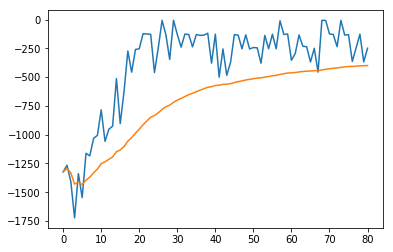

In [36]:
plt.plot(scores)
plt.plot(moving_scores)

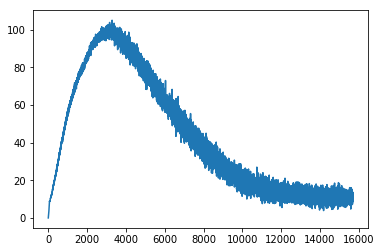

In [37]:
plt.plot(agent.actor_losses)

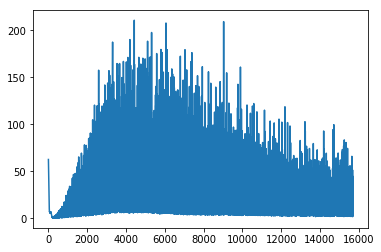

In [38]:
plt.plot(agent.critic_losses)

### Save Model

In [40]:
#save network of solved agent
# torch.save(agent.actor_local.state_dict(),f'models/ddpg.pth')
agent.actor_local.load_state_dict(torch.load(f'models/ddpg.pth'))
a = agent.actor_local

### Test Model

In [41]:
#somehow you need to do the animation import it again otherwise it wouldn't work
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [42]:
env = gym.make('Pendulum-v0')
state = env.reset()
score = 0
t=0
frames = []
while True:
    #only infer action; no training
    action = a(torch.FloatTensor(state)).detach().numpy()
    
    #env step
    state, reward, done, info = env.step(action)
    
    #book keeping
    t+=1
    score+=reward
    
    #break if done
    if done: break
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
print(f'Done in {t} timsteps with score {score}.')

Done in 200 timsteps with score -235.14101076477357.


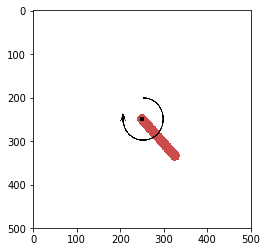

In [43]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())